### **TEMPO O3 validation**

This notebook illustrates comparison of TEMPO ozone total column retrievals with Pandora ground stations and DSCOVR EPIC retrievals.

It allows a user to choose Pandora station of interest. Since TEMPO spatial coverage is regional and limited to North America, it is user's responsibilty to select the station within TEMPO's field of regard (FOR). If the selected station is outside FOR, no TEMPO time series will be generated.

The user is allowed to choose the time period of interest by providing start and end dates in the form YYYYMMDD. Please be aware, that if the selecte period of interest is outside of available time span of one of the sensors, corresponding time series will not be generated.

DSCOVR L2 O3 data are interpolated to the location of the selected Pandora station.

Data files for all 3 sensors are downloaded on-the-fly. TEMPO and DSCOVR data are downloaded with earthaccess library that needs to be installed first.

TEMPO data files are read by means of netCDF library that needs to be installed first.

Pandora data files are ASCII files with header and space separated columns. Custome made function is included to read ozone total column along with its total uncertainty.

The resulting time series are plotted with and without uncertainty of Pandora measurement in the end of the notebook. Unlike TEMPO NO2 and HCHO retrievals, O3 retrievals do not have uncertainty written in the files.
DSCOVR data files also do not have uncertainty of O3 retrievals.

# 1 Installing and importing necessary libraries

## 1.1 Installing netCDF

In [ ]:
! pip3 install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.5 MB/s eta 0:00:00


## 1.2 Installing earthaccess

In [ ]:
! pip3 install earthaccess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 813.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu12=

## 1.3 Importing necessary libraries

In [ ]:
import earthaccess # needed to discover and download TEMPO data
import netCDF4 as nc # needed to read TEMPO data

import os
import sys

import platform
from subprocess import Popen
import shutil

from shapely.geometry import Point, Polygon # needed to search a point within a polygon
from scipy.interpolate import griddata # needed to interpolate TEMPO data to the point of interest
from scipy import stats # needed for linear regression analysis

import requests # needed to search for and download Pandora data
import codecs # needed to read Pandora data
import numpy as np

import h5py # needed to read DSCOVR_EPIC_L2_TO3 files
import matplotlib.pyplot as plt # needed to plot the resulting time series
from urllib.request import urlopen, Request # needed to search for and download Pandora data
from pathlib import Path # needed to check whether a needed data file is already downloaded
from datetime import datetime, timedelta # needed to work with time in plotting time series

#2 Defining functions to work with Pandora and TEMPO data

#2.1 functions to work with Pandora

###2.1.1 function creating the list of available Pandora sites

In [ ]:
def read_pandora_web():
  url = 'https://data.pandonia-global-network.org/'
  page = urlopen(url)
  html_bytes = page.read()
  html = html_bytes.decode("utf-8")
  html_len = len(html)

  pos1 = 0

  big_line = str(html)
  lines = big_line.split('\n')

  ref_lines = [i for i in lines if 'href' in i]
  refs = []
  for line in ref_lines:
    pos1 = line.find('"')
    pos2 = line.rfind('"')
    if pos1 > 0 and pos2 > pos1 and line[pos2-1] =='/' and line[pos1+1] == '.':
      refs.append(line[pos1+3 : pos2-1])

  return refs

###2.1.2 functions allowing user to choose a Pandora site of interest

In [ ]:
# function check_site checks whether user entered site is in the list of available Pandora sites
def check_site(site_name, refs):
  site_list = []
  for line in refs:
    if site_name in line:
      site_list.append(line)

  return site_list


# function take_pandora_sites takes user input and checks whether the site is in the list of available Pandora sites
def take_pandora_sites(refs):
  print('please select a Pandora site name from the list')
  for ref in refs:
    print(ref)

  answer = 'y'
  while answer == 'y':
    site_name = input('Enter a name of a Pandora site: ')
    print(site_name)
    site_list = check_site(site_name, refs)
    site_num = len(site_list)
    if site_num == 0:
      print('site ', site_name, 'was not found')
      continue

    if site_num > 1:
      print('there are ', site_num, ' site names, select one from')
      for site in site_list: print(site)

      site_name = input('Enter an exact name of a Pandora site: ')
      if site_list.count(site_name) != 1:
        print('Entered name is not the exact match of one of the following sites')
        for site in site_list: print(site)
        print('program terminated')
        sys.exit()

      for site in site_list:
        if site == site_name:
          pandora_site = site_name
          print('site ', site_name, 'was found and added to the list of sites ')
          break

    if site_num == 1:
      pandora_site = site_list[0]
      print('site ', site_list[0], 'was found and added to the list of sites ')

    answer = 'n'

  return pandora_site

###2.1.3 function creating the list links to O3 data files at the selected Pandora site

In [ ]:
# Pandora site may have several instruments. In this case each instrument has its own directory.
# However, the most recent version of the O3 data, rout2p1_8, is available only in one of these directories.
# The function creates all possible links, but some of them may be non-existing. This is checked and cleared later.
def instrument_path(site):
  url = 'https://data.pandonia-global-network.org/' + site + '/'
  page = urlopen(url)
  html_bytes = page.read()
  html = html_bytes.decode("utf-8")
  html_len = len(html)

  pos1 = 0
  big_line = str(html)
  lines = big_line.split('\n')

  ref_lines = [i for i in lines if 'href' in i]
  links = []
  for line in ref_lines:

    pos1 = line.find('"')
    pos2 = line.rfind('"')
    if pos1 > 0 and pos2 > pos1 and line[pos2-1] =='/' and\
       line[pos1+3 : pos1 + 10] == 'Pandora':
      link = url + line[pos1+3 : pos2] + 'L2/' + line[pos1+3 : pos2-1] + '_' + site + '_L2_rout2p1-8.txt'
      print(link)
      links.append(link)

  return links


# Defining functions downloading Pandora data file with given url
def download(url):
  response = requests.get(url)
  response_code = response.status_code

  file_name = url.split('/')[-1]

  if response_code == 200:
    content = response.content
    data_path = Path(file_name)
    data_path.write_bytes(content)

  return file_name, response_code

###2.1.4 functions reading Pandora O3 data file rout2p1-8

In [ ]:
# function read_timestamp converts Pandora timestamp of the format
# 'yyyymmddThhmmssZ' into a set of 6 numbers:
# integer year, month, day, hour, minute, and real second.
def read_timestamp(timestamp):

  yyyy = int(timestamp[0:4])
  mm = int(timestamp[4:6])
  dd = int(timestamp[6:8])
  hh = int(timestamp[9:11])
  mn = int(timestamp[11:13])
  ss = float(timestamp[13:17])

  return yyyy, mm, dd, hh, mn, ss


# function read_Pandora_O3_rout2p1_8. It is to be used for the future validation efforts.
# The difference with the original version is that instead of discriminating negative values of the total O3 column,
# it uses quality flags. It was previously found that QF == 0 does not occure often enough,
# so we will have to use QF == 10 (not-assured high quality).
#
# function read_Pandora_O3_rout2p1_8 reads Pandora total O3 column data files ending with rout2p1-8.
# Arguments:
# fname - name file to be read, string;
# start_date - beginning of the time interval of interest,
#              integer of the form YYYYMMDD;
# end_date -   end of the time interval of interest,
#              integer of the form YYYYMMDD.
#
# if start_date is greater than end_date, the function returns a numpy array
# with shape (0, 8), otherwise it returns an 8-column numpy array
# with with columns being year, month, day, hour, minute, second of observation
# and retrieved total O3 column along with its total uncertainty.
#
# O3 column and its uncertainties are in mol/m^2, so conversion to Dobson Units is
# performed by multiplication by DU_conversion = 1./4.4615E-04
def read_Pandora_O3_rout2p1_8_v2(fname, start_date, end_date):

  DU_conversion = 1./4.4615E-04

  data = np.empty([0, 8])
  if start_date > end_date: return -999., -999., data

  with codecs.open(fname, 'r', encoding='utf-8', errors='ignore') as f:

    while True:
# Get next line from file
      line = f.readline()

      if line.find('Short location name:') >= 0:
        loc_name = line.split()[-1] # location name, to be used in the output file name
        print('location name ', loc_name)

      if line.find('Location latitude [deg]:') >= 0:
        lat = float(line.split()[-1]) # location latitude
        print('location latitude ', lat)

      if line.find('Location longitude [deg]:') >= 0:
        lon = float(line.split()[-1]) # location longitude
        print('location longitude ', lon)

      if line.find('--------') >= 0: break

    while True:
# Get next line from file
      line = f.readline()

      if line.find('--------') >= 0: break

    while True:
# now reading line with data
      line = f.readline()

      if not line: break

      line_split = line.split()

      yyyy, mm, dd, hh, mn, ss = read_timestamp(line_split[0])
      date_stamp = yyyy*10000 + mm*100 + dd
      if date_stamp < start_date or date_stamp > end_date: continue

      QF = int(line_split[35]) # quality flag

      if QF == 0 or QF == 10:
        column = float(line_split[38])
#        column_unc = float(line_split[42]) # Total uncertainty of ozone total vertical column amount [moles per square meter]
        column_unc = float(line_split[43]) # rms-based uncertainty of ozone total vertical column amount [moles per square meter]
        data = np.append(data, [[yyyy, mm, dd, hh, mn, ss\
                               , column*DU_conversion\
                               , column_unc*DU_conversion]], axis = 0)

  return lat, lon, loc_name, data

#2.2 function to read DSCOVR O3 data files

In [ ]:
def read_epic_l2_to3(fname):
# function read_epic_l2_to3 reads DSCOVR_EPIC_L2_TO3 product file given by its fname
# and returns arrays of 2D latitudes and longitudes, and total O3 column
# along with their fill values and time.

  days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]


  try:
    f = h5py.File(fname, "r" )

    item = f['Latitude']
    lat2D = item[:]
#    fv_geo = item.fillvalue
    fv_geo = lat2D[0, 0]

    item = f['Longitude']
    lon2D = item[:]

    item = f['Ozone']
    o3_2D = item[:]
# commented out line below is the general way to read the fill value
# however, attribute '_FillValue' is not set for any array in the current version of the product
# at the same time, arrays do have apparent fill values that can be seen in the
# corners of the image
#    fv_o3 = item.fillvalue
    fv_o3 = o3_2D[0, 0]

# array 'YearDaySeconds' is a 3-element array giving year, day of the year,
# and second of the day values. These values correspond to the end of the
# interval of observation.
# For example for granule DSCOVR_EPIC_L2_TO3_03_20190626185044_03.h5
# these values are 2019, 177, and 67951, respectively. They correspond to
# '2019-06-26T18:52:31'
# which is the "RANGEENDINGTIME" in the granule's .met file
# The commented out part below should be un-commented
# if user prefers to use the end of of the interval of observation
# over the center of that interval given by the timestamp in the file name.
# In this case lines deriving time from the file name should be commented out.
    '''
    item = f['YearDaySeconds']
    YearDaySeconds = item[:] # this is an array of 3 elements: year, day of the year, and seconds of the day
# handling time first:
    yyyy= int(YearDaySeconds[0])
    dd = int(YearDaySeconds[1])
    sec = int(YearDaySeconds[2])

    md = days.copy()
    if (yyyy//4)*4 == yyyy: md[1] = md[1] + 1

    for i in range(12):
      if dd > md[i]: dd = dd - md[i]
    else:
      mm = i + 1
      break

    hh = sec//3600
    mn = sec//60 - hh*60
    ss = sec - hh*3600 - mn*60
    '''
    f.close()

# getting time from the granule's filename
    fname_split = fname.split('_')
    timestamp = fname_split[-2]
    yyyy= int(timestamp[0 : 4])
    mm = int(timestamp[4 : 6])
    dd = int(timestamp[6 : 8])
    hh = int(timestamp[8 : 10])
    mn = int(timestamp[10 : 12])
    ss = int(timestamp[12 : 14])

  except:
    print("Unable to find or read hdf5 input granule file ", fname)
    lat2D = 0.
    lon2D = 0.
    o3_2D = 0.
    fv_o3 = 0.
    fv_geo = 0.
    yyyy = 0
    mm = 0
    dd = 0
    hh = 0
    mn = 0
    ss = 0

  return lat2D, lon2D, o3_2D, fv_o3, fv_geo, yyyy, mm, dd, hh, mn, ss

#2.3 functions to work with TEMPO

###2.3.1 function reading TEMPO_O3TOT_L2

In [ ]:
def read_TEMPO_O3TOT_L2(fn):
  '''
  function read_TEMPO_O3TOT_L2 reads the following arrays from the
  TEMPO L2 O3 product TEMPO_O3TOT_L2_V01:
    column_amount_o3;
  and returns respective fields along with coordinates of the pixels.

  If one requested variables cannot be read, all returned variables are zeroed
  '''
  var_name = 'column_amount_o3'
  var_QF_name = 'quality_flag'

  try:
    ds = nc.Dataset(fn)

    prod = ds.groups['product'] # this opens group product, /product, as prod

    var = prod.variables[var_name] # this reads variable column_amount_o3 from prod (group product, /product)
    total_O3_column = np.array(var)
    fv_prod = var.getncattr('_FillValue')
    prod_unit = var.getncattr('units')

    var_QF = prod.variables[var_QF_name] # this reads variable column_amount_o3 from prod (group product, /product)
    total_O3_column_QF = np.array(var_QF)

    geo = ds.groups['geolocation'] # this opens group geolocation, /geolocation, as geo

    lat = np.array(geo.variables['latitude']) # this reads variable latitude from geo (geolocation group, /geolocation) into a numpy array
    lon = np.array(geo.variables['longitude']) # this reads variable longitude from geo (geolocation group, /geolocation) into a numpy array
    fv_geo = geo.variables['latitude'].getncattr('_FillValue')
    time = np.array(geo.variables['time'] )# this reads variable longitude from geo (geolocation group, /geolocation) into a numpy array

  except:
    print('variable '+var_name+' cannot be read in file '+fn)
    lat = 0.
    lon = 0.
    time = 0.
    fv_geo = 0.
    total_O3_column = 0.
    total_O3_column_QF = 0.
    fv_prod = 0.
    prod_unit = ''

  return lat, lon, fv_geo, time, total_O3_column, total_O3_column_QF\
, fv_prod, prod_unit

###2.3.2 function creating TEMPO O3 granule polygon

In [ ]:
def TEMPO_L2_polygon(lat, lon, fv_geo):
  nx = lon.shape[0]
  ny = lon.shape[1]
  print('granule has %3d scanlines by %4d pixels' %(nx, ny))

  dpos = np.empty([0,2])

  x_ind = np.empty([nx, ny], dtype = int) # creating array in x indices
  for ix in range(nx): x_ind[ix, :] = ix # populating array in x indices
  y_ind = np.empty([nx, ny], dtype = int)
  for iy in range(ny): y_ind[:, iy] = iy # populating array in x indices

  mask = (lon[ix, iy] != fv_geo)&(lat[ix, iy] != fv_geo)
  if len(lon[mask]) == 0:
    print('the granule is empty - no meaningful positions')
    return dpos

# right boundary
  r_m = min(x_ind[mask].flatten())
  local_mask = (lon[r_m, :] != fv_geo)&(lat[r_m, :] != fv_geo)
  r_b = np.stack((lon[r_m, local_mask], lat[r_m, local_mask])).T

# left boundary
  l_m = max(x_ind[mask].flatten())
  local_mask = (lon[l_m, :] != fv_geo)&(lat[l_m, :] != fv_geo)
  l_b = np.stack((lon[l_m, local_mask], lat[l_m, local_mask])).T

#top and bottom boundaries
  t_b = np.empty([0,2])
  b_b = np.empty([0,2])
  for ix in range(r_m + 1, l_m):
    local_mask = (lon[ix, :] != fv_geo)&(lat[ix, :] != fv_geo)
    local_y_ind = y_ind[ix, local_mask]
    y_ind_top = min(local_y_ind)
    y_ind_bottom = max(local_y_ind)
    t_b = np.append(t_b, [[lon[ix, y_ind_top], lat[ix, y_ind_top]]], axis=0)
    b_b = np.append(b_b, [[lon[ix, y_ind_bottom], lat[ix, y_ind_bottom]]], axis=0)

# combining right, top, left, and bottom boundaries together, going along the combined boundary counterclockwise
  dpos = np.append(dpos, r_b[ : :-1, :], axis=0) # this adds right boundary, counterclockwise
  dpos = np.append(dpos, t_b, axis=0) # this adds top boundary, counterclockwise
  dpos = np.append(dpos, l_b, axis=0) # this adds left boundary, counterclockwise
  dpos = np.append(dpos, b_b[ : :-1, :], axis=0) # this adds bottom boundary, counterclockwise

  print('polygon shape: ',dpos.shape)

  return dpos

##2.4 auxiliary functions to handle data

###2.4.1 function smoothing Pandora retievals and interpolating them onto TEMPO times of observations

In [ ]:
# Smooth Pandora retievals and interplate them into other time series times
# Pandora timeseries has significantly more data points then TEMPO and DSCOVR. It is also very noisy.
# To make comparison easier, Pandora timeseries is interpolated to the moments of TEMPO and DSCOVR observations.

# Interpolation is performed by the function defined below with the help of Gaussian smooting as follow:
# x_int(t) = SUM(x_p(t_i)*wt(t_i, t)),
#
# wt(t_i, t) = exp(-(t - t_i)^2/(2 * sigma^2))/SUM(exp(-(t - t_i)^2/(2 * sigma^2))),
#
# where sums are taken over times t_i falling into time interval (t-dt_max, t+dt_max).
#
# Parameters dt_max and sigma can be chosen by the user.
def gauss_interpolation(timeseries, new_times):
#
# function gauss_interpolation takes 2D array timeseries with function
# to be interpolated and 1D array new_times containing times to which
# the function is to be interpolated
# arguments:
#     timeseries - array with at least 2 columns,
#                  1st column - times, 2nd (3rd, ...) column(s) - function to be interpolated
#     new_times  - 1D array of times to which the function(s) to be interpolated
#
# parameters
# dt_max = 0.0041666667 - 6 minutes expressed in days
# sigma = 0.00041666667 - 36 seconds expressed in days

  dt_max = 0.0041666667 # 6 minutes expressed in days
  sigma = 0.00041666667 # 36 seconds expressed in days

  nnt = len(new_times)
  (nt, nfun) = timeseries.shape

  timeseries_smooth = np.empty([0, nfun])

  for new_time in new_times:
    llim = new_time - dt_max
    ulim = new_time + dt_max

    timeseries_subset = timeseries[((timeseries[:, 0] < ulim)\
                                    & (timeseries[:, 0] > llim))]
    if len(timeseries_subset) < 1: continue
    t_delta = timeseries_subset[:, 0] - new_time
    wt = np.exp(-t_delta**2/(2.*sigma**2))
    wt = wt/np.sum(wt)

    timeseries_smooth_loc = np.array([new_time])
    for ifun in range(1, nfun):
      timeseries_smooth_loc = np.append(timeseries_smooth_loc,\
                                        np.sum(timeseries_subset[:, ifun]*wt))

    timeseries_smooth = np.append(timeseries_smooth,\
                                  np.array([timeseries_smooth_loc]), axis = 0)

  return timeseries_smooth

###2.4.2 function computing linear regression with zero intercept

In [ ]:
# custom made function regress_0intercept takes vectors x and y
# representing coordinates and function values at these coordinates
# and returns slope of regression fit y = a*x
# along with coefficient of determination
def regress_0intercept(x, y):
  success = False

  if len(x) != len(y):
    a = 0.
    R2 = 0.

  elif len(x) == 1:
    if x[0] != 0.:
      a = y[0]/x[0]
      R2 = 1.
      success = True
    else:
      if y[0] != 0.:
        a = np.inf
        R2 = 1.
        success = True
      else:
        a = np.inf
        R2 = 0.

  else:
    xy_sum = np.dot(x, y)
    x2_sum = np.dot(x, x)
    a = xy_sum/x2_sum

    res_y = y - a*x
    res_sum_2 = np.dot(res_y, res_y)
    y2_sum = np.dot(y, y)
    sum_tot_2 = y2_sum - len(y)*np.mean(y)**2
    R2 = 1. - res_sum_2/sum_tot_2

    success = True

  return success, a, R2

#Main code begins here

#3 Establishing access to EarthData

##3.1 Logging in

User needs to create an account at https://www.earthdata.nasa.gov/

Function earthaccess.login prompts for EarthData login and password.

In [ ]:
# Establishing access to EarthData
# User needs to create an account at https://www.earthdata.nasa.gov/
# Function earthaccess.login prompts for EarthData login and password.
auth = earthaccess.login(strategy="interactive", persist=True)

Enter your Earthdata Login username: alexrad71
Enter your Earthdata password: ··········
Persisting credentials to .netrc


##3.2 Creating local directory

In [ ]:
homeDir = os.path.expanduser("~") + os.sep

with open(homeDir + '.dodsrc', 'w') as file:
    file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
    file.write('HTTP.NETRC={}.netrc'.format(homeDir))
    file.close()

print('Saved .dodsrc to:', homeDir)

# Set appropriate permissions for Linux/macOS
if platform.system() != "Windows":
    Popen('chmod og-rw ~/.netrc', shell=True)
else:
    # Copy dodsrc to working directory in Windows
    shutil.copy2(homeDir + '.dodsrc', os.getcwd())
    print('Copied .dodsrc to:', os.getcwd())

Saved .dodsrc to: /root/


#4 Working with Pandora data

##4.1 Discovering existing Pandora stations and selecting one of them

In [ ]:
# Discovering available Pandora site.
# Please bear in mind that some sites do not have NO2 data files
print('gathering Pandora sites information')
refs = read_pandora_web()

pandora_site = take_pandora_sites(refs) # create list of Pandora sites of interest
print('the following sites were selected')
print(pandora_site)
print('from the list of existing Pandora sites')

# create a list of !AVAILABLE! Pandora files for the Pandora site
pandora_files = []

links = instrument_path(pandora_site)

npfiles = 0

for link in links:
  pandora_fname = link.split('/')[-1]

# check if file exists in the local directory, if not download from Pandora site
  if not os.path.exists(pandora_fname):
    print(pandora_fname,' does not exit in local directory, downloading from the web')
    print(link)

    pandora_fname, response_code = download(link)

    if response_code == 200:
      print('Pandora L2 file ', pandora_fname, ' has been downloaded')
      npfiles = npfiles + 1
      pandora_files.append(pandora_fname)
    else:
      print('Pandora L2 file ', link, ' does not exist')

  else:
    print(pandora_fname,' exits in local directory')
    npfiles = npfiles + 1
    pandora_files.append(pandora_fname)

if npfiles == 0: # no files were found, STOP here
  print('no files were found for Pandora site ', pandora_site, 'program terminated')
  sys.exit()
if npfiles > 1: # normally there should be only one file per site. if there are more - STOP
  print('there are too many files for site ', pandora_site, '- STOP and investigate file names below. Program terminated')
  for pandora_fname in pandora_files: print(pandora_fname)
  sys.exit()

gathering Pandora sites information
please select a Pandora site name from the list
Agam
AldineTX
AliceSprings
Altzomoni
ArlingtonTX
Athens-NOA
AtlantaGA-SouthDeKalb
AtlantaGA
AustinTX
Bandung
Bangkok
Banting
BayonneNJ
Beijing-RADI
BeltsvilleMD
Berlin
BlueHillMA
BostonMA
BoulderCO-NCAR
BoulderCO
Bremen
BristolPA
BronxNY
Brussels-Uccle
Bucharest
BuenosAires
BuffaloNY
Busan
Cabauw
calibrationfiles
CambridgeMA
CameronLA
CapeElizabethME
ChapelHillNC
CharlesCityVA
ChiangMai
ChicagoIL
Cologne
ComodoroRivadavia
Cordoba
CornwallCT
Dalanzadgad
Davos
DearbornMI
Dhaka
Downsview
EastProvidenceRI
EdwardsCA
Egbert
Eureka-PEARL
FairbanksAK
Fajardo
FortMcKay
FortYatesND
Fukuoka
Gongju-KNU
Granada
GrandForksND
GreenbeltMD
HamptonVA-HU
HamptonVA
Helsinki
HoustonTX-SanJacinto
HoustonTX
HuntsvilleAL
Incheon-ESC
Innsbruck
IowaCityIA-WHS
Islamabad-NUST
Izana
Juelich
KenoshaWI
Kobe
Kosetice
LaPorteTX
LapwaiID
LibertyTX
Lindenberg
LondonderryNH
LynnMA
MadisonCT
ManhattanKS
ManhattanNY-CCNY
MaunaLoaHI
MexicoCi

##4.2 Selecting timeframe of interest

It is going to be common for both instruments

In [ ]:
print('enter period of interest, start and end dates, in the form YYYYMMDD')
datestamp_ini = input('enter start date of interest ')
datestamp_fin = input('enter end date of interest ')

start_date = int(datestamp_ini)
end_date = int(datestamp_fin)

yyyy_ini = start_date//10000
mm_ini = (start_date//100 - yyyy_ini*100)
dd_ini = (start_date - yyyy_ini*10000 - mm_ini*100)

yyyy_fin = end_date//10000
mm_fin = (end_date//100 - yyyy_fin*100)
dd_fin = (end_date - yyyy_fin*10000 - mm_fin*100)
print(yyyy_ini, mm_ini, dd_ini, yyyy_fin, mm_fin, dd_fin)

date_start = str('%4.4i-%2.2i-%2.2i 00:00:00' %(yyyy_ini, mm_ini, dd_ini))
date_end = str('%4.4i-%2.2i-%2.2i 23:59:59' %(yyyy_fin, mm_fin, dd_fin))

enter period of interest, start and end dates, in the form YYYYMMDD
enter start date of interest 20230901
enter end date of interest 20230901
2023 9 1 2023 9 1


##4.3 Reading Pandora file within selected timeframe and create point of interest

In [ ]:
pandora_file = pandora_files[0]
lat, lon, POI_name, Pandora_data = read_Pandora_O3_rout2p1_8_v2(pandora_file, start_date, end_date)

if lat == -999.:
  print('error reading pandora file ', pandora_file, 'program terminated')
  sys.exit()

POI = np.array([lat, lon])

# print # of points in Pandora timeseries
n_Pandora_data = len(Pandora_data)
print(n_Pandora_data,\
' Pandora measurements found within period of interes between',\
date_start, 'and', date_end)
if n_Pandora_data == 0:
  print('program terminated')
  sys.exit()


location name  Toronto-Scarborough
location latitude  43.7843
location longitude  -79.1874
94  Pandora measurements found within period of interes between 2023-09-01 00:00:00 and 2023-09-01 23:59:59


##4.4 Setting TEMPO name constants and writing Pandora timeseries to a file

In [ ]:
# Setting TEMPO name constants
short_name_TEMPO = 'TEMPO_O3TOT_L2' # collection name to search for in the EarthData
out_Q = 'tot_O3_col' # name of the output quantity with unit
out_Q_unit = out_Q+',_DU' # name of the output quantity with unit

# write Pandora timeseries to a file
POI_name_ = POI_name.replace(' ','_')

Pandora_out = open(out_Q+'_Pandora_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'w')
for line in Pandora_data:
  Pandora_out.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %4.1f %12.4e %12.4e\n'\
 %(line[0], line[1], line[2], line[3], line[4], line[5], line[6], line[7])))
Pandora_out.close()

#5 Working with DSCOVR data

##5.1 Searching for DSCOVR data files in the selected thimeframe and download them

In [ ]:
short_name_DSCOVR = 'DSCOVR_EPIC_L2_TO3' # collection name to search for in the EarthData

POI_lat = POI[0]
POI_lon = POI[1]
bbox = (POI_lon - 0.5, POI_lat - 0.5, POI_lon + 0.5, POI_lat + 0.5)

POI_results_EPIC = earthaccess.search_data(short_name = short_name_DSCOVR\
                                         , temporal = (date_start, date_end)\
                                          )
# Searching DSCOVR data files without bounding box
# It appears that as of now, January 19, 2024, earthaccess returns incorrect granules for DSCOVR product covering anti-meridian.
# For this reason, all available granules should be grabbed using earthaccess function search_data without bounding box.
# Granules that do not contain the point of interest will be processed,
# but the code below will handle them correctly without generating either errors or fill value outcome.
# Once the problem with collection DSCOVR_EPIC_L2_TO3_03 is resolved,
# the line below should be uncommented while the line before this commen should be removed.
#                                         , bounding_box = bbox)

n_EPIC = len(POI_results_EPIC)

print('total number of DSCOVR EPIC L2_TO3 granules found for POI', POI_name\
    , '\nwithin period of interes between', date_start, 'and', date_end, '\nis', n_EPIC)

# lines below before the call of earthaccess.download()
# check whether all found granules have download links.
# granules without links are removed from the list of search results
# without this step, those granules crash the call of earthaccess.download()
granule_links_EPIC = []
POI_results_EPIC_bad = []
for result in POI_results_EPIC:
  try:
    granule_links_EPIC.append(result['umm']['RelatedUrls'][0]['URL'])
  except:
    POI_results_EPIC_bad.append(result)

for granule_link in granule_links_EPIC: print(granule_link)
for result in POI_results_EPIC_bad: POI_results_EPIC.remove(result)

downloaded_files = earthaccess.download(POI_results_EPIC, local_path='.',)

# Checking whether all DSCOVR EPIC data files have been downloaded
for granule_link in granule_links_EPIC:
  EPIC_fname = granule_link.split('/')[-1]
# check if file exists in the local directory
  if not os.path.exists(EPIC_fname):
    print(EPIC_fname, 'does not exist in local directory')
# repeat attempt to download
    downloaded_files = earthaccess.download(granule_link,
                                            local_path='.')
# if file still does not exist in the directory, remove its link from the list of links
    if not os.path.exists(EPIC_fname): granule_links_EPIC.remove(granule_link)

Granules found: 22
total number of DSCOVR EPIC L2_TO3 granules found for POI Toronto-Scarborough 
within period of interes between 2023-09-01 00:00:00 and 2023-09-01 23:59:59 
is 22
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_20230901211054_03.h5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_20230901013240_03.h5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_20230901200526_03.h5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_20230901221622_03.h5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_20230901133241_03.h5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_20230901143809_03.h5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03_20230901112146_03.h5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_TO3_03/2023/09/DSCOVR_EPIC_L2_TO3_03

QUEUEING TASKS | :   0%|          | 0/21 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/21 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/21 [00:00<?, ?it/s]

##5.2 Compiling DSCOVR EPIC total ozone timeseries

In [ ]:
geo_deviation = 0.1 # deviation from the point of interest, degree

out_Q_EPIC = 'tot_O3_EPIC'
out_Q_unit = 'DU'

fout = open(out_Q_EPIC+'_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'w')
fout.write('timeseries of '+out_Q_EPIC+' at '+POI_name+' '+str('%08.4fN %08.4fW' %(POI[0], -POI[1]))+'\n')
fout.write('yyyy mm dd hh mn ss '+out_Q_unit+'\n')

# for result in POI_results_EPIC:
for granule_link in sorted(granule_links_EPIC):
  last_slash_ind = granule_link.rfind('/')
  fname = granule_link[last_slash_ind+1 : ]
  print('\n'+fname)
  lat2D, lon2D, o3_2D, fv_o3, fv_geo, yyyy, mm, dd, hh, mn, ss =\
 read_epic_l2_to3(fname)

  if isinstance(lat2D, float): continue

  nx = lon2D.shape[0]
  ny = lon2D.shape[1]

# check whether POI is in the granule. If not - move to the next granule
  mask = (lat2D < POI_lat+geo_deviation)&(lat2D > POI_lat-geo_deviation)\
        &(lon2D < POI_lon+geo_deviation)&(lon2D > POI_lon-geo_deviation)\
        &(o3_2D != fv_o3)&(o3_2D > 0.)\

  lat_loc = lat2D[mask]
  lon_loc = lon2D[mask]
  o3_loc = o3_2D[mask]
  n_loc = len(o3_loc)
  if n_loc < 1: continue

  pp = np.array([POI[1], POI[0]])
  points = np.empty([0,2])
  ff = np.empty(0)

  for i in range(n_loc):
    if o3_loc[i] == fv_o3 or o3_loc[i] < 0: continue
    points = np.append(points, [[lon_loc[i], lat_loc[i]]], axis=0)
    ff = np.append(ff, o3_loc[i])

  try:
    [prod_loc] = griddata(points, ff, pp, method='linear', fill_value=-1., rescale=False)
  except:
    try:
      prod_loc = np.mean(ff)
    except: continue
  if prod_loc == -1.: continue

  print(yyyy, mm, dd, hh, mn, ss, prod_loc)

  fout.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %2.2i %10.3e '\
 %(yyyy, mm, dd, hh, mn, ss, prod_loc)))
  for i in range(n_loc):
    fout.write(str('%9.4fN %9.4fW %10.3e '\
 %(lat_loc[i], -lon_loc[i], o3_loc[i])))
  fout.write('\n')

fout.close()


DSCOVR_EPIC_L2_TO3_03_20230901002713_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901013240_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901023807_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901034335_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901044902_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901065957_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901080524_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901091052_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901101619_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901112146_03.h5

DSCOVR_EPIC_L2_TO3_03_20230901122714_03.h5
2023 9 1 12 27 14 298.1773223876953

DSCOVR_EPIC_L2_TO3_03_20230901133241_03.h5
2023 9 1 13 32 41 299.6849670410156

DSCOVR_EPIC_L2_TO3_03_20230901143809_03.h5
2023 9 1 14 38 9 302.0566994892939

DSCOVR_EPIC_L2_TO3_03_20230901154336_03.h5
2023 9 1 15 43 36 302.94395136036707

DSCOVR_EPIC_L2_TO3_03_20230901164904_03.h5
2023 9 1 16 49 4 305.0194543839239

DSCOVR_EPIC_L2_TO3_03_20230901175431_03.h5
2023 9 1 17 54 31 302.3306781421441

DSCOVR_EPIC_L2_TO3_03_20230901185959_03.h5
2023 9 1 18 59 59 305.62217221535025


#6 Working with TEMPO data

##6.1 Searching TEMPO data files within 0.5 degree range around the POI (position of the Pandora station)

In [ ]:
# Searching TEMPO data files within 0.5 degree range around the POI (position of the Pandora station)
POI_lat = POI[0]
POI_lon = POI[1]
bbox = (POI_lon - 0.5, POI_lat - 0.5, POI_lon + 0.5, POI_lat + 0.5)

for version in ['V02', 'V01']:
  POI_results = earthaccess.search_data(short_name = short_name_TEMPO\
                                      , version = version\
                                      , temporal = (date_start, date_end)\
                                      , bounding_box = bbox)
  n_gr = len(POI_results)
  if n_gr == 0: continue
  print('total number of TEMPO version ', version,' granules found for POI', POI_name, \
        '\nwithin period of interes between', date_start, 'and', date_end, ' is', n_gr)
  break

if n_gr == 0:
  print('program terminated')
  sys.exit()

Granules found: 13
total number of TEMPO version  V02  granules found for POI Toronto-Scarborough 
within period of interes between 2023-09-01 00:00:00 and 2023-09-01 23:59:59  is 13


##6.2 Printing explicit links to the granules and downloading the files

In [ ]:
# Printing explicit links to the granules.
granule_links = []
for result in POI_results: granule_links.append(result['umm']['RelatedUrls'][0]['URL'])
for granule_link in granule_links: print(granule_link)

# Downloading TEMPO data files
downloaded_files = earthaccess.download(
    POI_results,
    local_path='.')

# Checking whether all TEMPO data files have been downloaded
for granule_link in granule_links:
  TEMPO_fname = granule_link.split('/')[-1]
# check if file exists in the local directory
  if not os.path.exists(TEMPO_fname):
    print(TEMPO_fname, 'does not exist in local directory')
# repeat attempt to download
    downloaded_files = earthaccess.download(granule_link,
                                            local_path='.')
# if file still does not exist in the directory, remove its link from the list of links
    if not os.path.exists(TEMPO_fname): granule_links.remove(granule_link)

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V02/2023.09.01/TEMPO_O3TOT_L2_V02_20230901T111453Z_S001G04.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V02/2023.09.01/TEMPO_O3TOT_L2_V02_20230901T114616Z_S002G04.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V02/2023.09.01/TEMPO_O3TOT_L2_V02_20230901T121739Z_S003G04.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V02/2023.09.01/TEMPO_O3TOT_L2_V02_20230901T124902Z_S004G04.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V02/2023.09.01/TEMPO_O3TOT_L2_V02_20230901T132025Z_S005G04.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V02/2023.09.01/TEMPO_O3TOT_L2_V02_20230901T135148Z_S006G04.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V02/2023.09.01/TEMPO_O3TOT_L2_V02_20230901T142311Z_S007G04.nc
https://data.asdc.ea

QUEUEING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/13 [00:00<?, ?it/s]

##6.3 Compiling TEMPO ozone total column time series

In [ ]:
days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

fout = open(out_Q+'_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'w')
fout.write('timeseries of '+out_Q+' at '+POI_name+' '+str('%08.4fN %08.4fW' %(POI[0], -POI[1]))+'\n')
fout.write('yyyy mm dd hh mn ss '+out_Q_unit+'\n')

for granule_link in sorted(granule_links):
  last_slash_ind = granule_link.rfind('/')
  fname = granule_link[last_slash_ind+1 : ]
  print('\ngranule ', fname)
  lat, lon, fv_geo, time, total_O3_column, total_O3_column_QF\
, fv_prod, prod_unit = read_TEMPO_O3TOT_L2(fname)

  if isinstance(lat, float): continue

# it appeared that garbage values of latitudes and longitudes in the L2 files
# are 9.969209968386869E36 while fill value is -1.2676506E30
# (after deeper search it was found that actual value in the file is -1.2676506002282294E30).
# For this reason, fv_geo is set to 9.96921E36 to make the code working.
# Once the problem is resolved and garbage values of latitudes and longitudes
# equal to their fill value, the line below must be removed.
  fv_geo = 9.969209968386869E36

  polygon = TEMPO_L2_polygon(lat, lon, fv_geo)

  coords_poly = list(polygon)
  poly = Polygon(coords_poly)

  nx = lon.shape[0]
  ny = lon.shape[1]

# getting time from the granule filename.
# This time corresponds to the 1st element of array time above which is GPS time in seconds
  Tind = fname.rfind('T')
  yyyy= int(fname[Tind-8 : Tind-4])
  mm = int(fname[Tind-4 : Tind-2])
  dd = int(fname[Tind-2 : Tind])
  hh = int(fname[Tind+1 : Tind+3])
  mn = int(fname[Tind+3 : Tind+5])
  ss = float(fname[Tind+5 : Tind+7])

# check whether POI is in the granule. If not - move to the next granule
  pp = np.array([POI[1], POI[0]])
  p = Point(pp) # POI[0] - latitudes, POI[1] - longitudes
  if not p.within(poly):
    print('point', POI[0], POI[1], 'is not within the granule polygon' )
    continue
  print('point', POI[0], POI[1], 'is within the granule polygon' )

  POI_found = False
  for ix in range(nx-1):
    for iy in range(ny-1):
      if lon[ix, iy] == fv_geo: continue
      if lat[ix, iy] == fv_geo: continue
      if lon[ix, iy+1] == fv_geo: continue
      if lat[ix, iy+1] == fv_geo: continue
      if lon[ix+1, iy+1] == fv_geo: continue
      if lat[ix+1, iy+1] == fv_geo: continue
      if lon[ix+1, iy] == fv_geo: continue
      if lat[ix+1, iy] == fv_geo: continue

      coords_poly_loc = [[lon[ix, iy], lat[ix, iy]], [lon[ix, iy+1], lat[ix, iy+1]] \
                   , [lon[ix+1, iy+1], lat[ix+1, iy+1]], [lon[ix+1, iy], lat[ix+1, iy]]]
      poly_loc = Polygon(coords_poly_loc)

      if p.within(poly_loc):
        print('scanl pixel latitude longitude O3_col O3_col_QF')
        for scl in range(ix, ix+2, 1):
          for pix in range(iy, iy+2, 1):
            print("  %3d %4d %9.6f %10.6f %5.1f %6i"\
 %(scl, pix, lat[scl, pix], lon[scl, pix]\
, total_O3_column[scl, pix], total_O3_column_QF[scl, pix]))

        POI_found = True
        print('POI', POI_name, 'at', POI[1], POI[0], ' found')

        total_O3_column_loc = np.array([total_O3_column[ix, iy],\
                                        total_O3_column[ix, iy+1],\
                                        total_O3_column[ix+1, iy+1],\
                                        total_O3_column[ix+1, iy]])
        total_O3_column_QF_loc = np.array([total_O3_column_QF[ix, iy],\
                                           total_O3_column_QF[ix, iy+1],\
                                           total_O3_column_QF[ix+1, iy+1],\
                                           total_O3_column_QF[ix+1, iy]])
        lat_loc = np.array([lat[ix, iy], lat[ix, iy+1],\
                            lat[ix+1, iy+1], lat[ix+1, iy]])
        lon_loc = np.array([lon[ix, iy], lon[ix, iy+1],\
                            lon[ix+1, iy+1], lon[ix+1, iy]])
        mask_noFV  = (total_O3_column_loc != fv_prod)&\
                     (total_O3_column_QF_loc == 0)

        points_noFV  = np.column_stack((lon_loc[mask_noFV], lat_loc[mask_noFV]))
        ff_noFV  = total_O3_column_loc[mask_noFV]

        points = np.empty([0,2])
        ff = np.empty(0)

        if ff_noFV.shape[0] == 0:
          continue
        elif ff_noFV.shape[0] < 4:
          total_O3_column_noFV = np.mean(ff_noFV)
        elif ff_noFV.shape[0] == 4:
          total_O3_column_noFV = griddata(points_noFV, ff_noFV, pp,\
method='linear', fill_value=-1., rescale=False)[0]
        if total_O3_column_noFV == -1.: continue

# handling time first:
        delta_t = (time[ix+1] + time[ix])*0.5 - time[0]
        ss = ss + delta_t
        if ss >= 60.:
          delta_mn = int(ss/60.)
          ss = ss - 60.*delta_mn
          mn = mn + delta_mn
          if mn >= 60:
            mn = mn - 60
            hh = hh + 1
            if hh == 24:
              hh = hh - 24
              dd = dd + 1
              day_month = days[mm]
              if (yyyy//4)*4 == yyyy and mm == 2: day_month = day_month + 1
              if dd > day_month:
                dd = 1
                mm = mm + 1
                if mm > 12:
                  mm = 1
                  yyyy = yyyy + 1

        fout.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %2.2i %10.3e '\
 %(yyyy, mm, dd, hh, mn, ss, total_O3_column_noFV)))
        fout.write(str('%9.4fN %9.4fW %10.3e '\
 %(lat[ix, iy], -lon[ix, iy], total_O3_column[ix, iy])))
        fout.write(str('%9.4fN %9.4fW %10.3e '\
 %(lat[ix, iy+1], -lon[ix, iy+1], total_O3_column[ix, iy+1])))
        fout.write(str('%9.4fN %9.4fW %10.3e '\
 %(lat[ix+1, iy+1], -lon[ix+1, iy+1], total_O3_column[ix+1, iy+1])))
        fout.write(str('%9.4fN %9.4fW %10.3e\n'\
 %(lat[ix+1, iy], -lon[ix+1, iy], total_O3_column[ix+1, iy])))

        break

    if POI_found: break

fout.close()


granule  TEMPO_O3TOT_L2_V02_20230901T111453Z_S001G04.nc
granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
point 43.7843 -79.1874 is within the granule polygon


<ipython-input-9-7a061a7ce8bc>:24: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  total_O3_column_QF = np.array(var_QF)


scanl pixel latitude longitude O3_col O3_col_QF
   34  514 43.798702 -79.178795 330.8     12
   34  515 43.776325 -79.183784 326.3     10
   35  514 43.796459 -79.239937 319.9     10
   35  515 43.774055 -79.244926 334.6     12
POI Toronto-Scarborough at -79.1874 43.7843  found

granule  TEMPO_O3TOT_L2_V02_20230901T114616Z_S002G04.nc
granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
point 43.7843 -79.1874 is within the granule polygon
scanl pixel latitude longitude O3_col O3_col_QF
   34  514 43.797798 -79.158958 286.6      8
   34  515 43.775368 -79.163994 286.3      8
   35  514 43.796032 -79.219315 287.5      8
   35  515 43.773708 -79.224266 285.9      8
POI Toronto-Scarborough at -79.1874 43.7843  found

granule  TEMPO_O3TOT_L2_V02_20230901T121739Z_S003G04.nc
granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
point 43.7843 -79.1874 is within the granule polygon
scanl pixel latitude longitude O3_col O3_col_QF
   34  514 43.791622 -79.169304 290.8   

#7 Plotting the results

##7.1 Reading created data files for TEMPO, create timeseries

In [ ]:
# Plotting the results
# Reading created data files for TEMPO and DSCOVR, create timeseries

# reading TEMPO file that was created at the previous step
# only read POI information from the header and first 8 columns of data:
#   yyyy, mm, dd, hh, mn, ss, O3 column, and its incertainty
fout = open(out_Q+'_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'r')

header1 = fout.readline()
header2 = fout.readline()
data_lines = fout.readlines()

fout.close()

yyyy = yyyy_ini
mm = mm_ini
dd = dd_ini
hh = 0
mn = 0
ss = 0
dt0 = datetime(yyyy, mm, dd, hh, mn, ss)

yyyy = yyyy_fin
mm = mm_fin
dd = dd_fin
hh = 23
mn = 59
ss = 59
dt_fin = datetime(yyyy, mm, dd, hh, mn, ss) # this is time 1 second before the end of the timeframe of interest

time_series_TEMPO = np.empty([0, 2])

if len(data_lines) > 0:
  for line in data_lines:
    split = line.split()
    yyyy = int(split[0])
    mm = int(split[1])
    dd = int(split[2])
    hh = int(split[3])
    mn = int(split[4])
    ss = int(split[5])
# dt below is time since the beginning of the eriod of interest in hours
    dt = (datetime(yyyy, mm, dd, hh, mn, ss) - dt0).total_seconds()/86400.
    time_series_TEMPO = np.append(time_series_TEMPO,\
 [[dt, float(split[6])]], axis = 0)

if len(time_series_TEMPO) == 0:
  print('TEMPO timeseries does not have data. STOP')
  sys.exit()

TEMPO timeseries does not have data. STOP


SystemExit: 

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


#COMMENT ON THE FURTHER DEVELOPMENT
There may be a situation when there is no single TEMPO pixels with quality flag 0. For this reason, TEMPO time series does not have a single point. The problem of very sparse QF==0 pixels was previously documented. User should be cautious using the data.

If user does have data points in TEMPO timeseries, the rest of the notebook is intended to visualize the results.

##7.2 creating DSCOVR timeseries

In [ ]:
# reading DSCOVR file that was created at the previous step
# only read POI information from the header and first 8 columns of data:
#   yyyy, mm, dd, hh, mn, ss, and O3 column
fout = open(out_Q_EPIC+'_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'r')

header1 = fout.readline()
header2 = fout.readline()
data_lines = fout.readlines()

fout.close()

time_series_DSCOVR = np.empty([0, 2])

if len(data_lines) > 0:
  for line in data_lines:
    split = line.split()
    yyyy = int(split[0])
    mm = int(split[1])
    dd = int(split[2])
    hh = int(split[3])
    mn = int(split[4])
    ss = int(split[5])
# dt below is time since the beginning of the eriod of interest in hours
    dt = (datetime(yyyy, mm, dd, hh, mn, ss) - dt0).total_seconds()/86400.
    time_series_DSCOVR = np.append(time_series_DSCOVR,\
 [[dt, float(split[6])]], axis = 0)

##7.3 creating Pandora timeseries

In [ ]:
time_series_Pandora = np.empty([0, 3])

for line in Pandora_data:
  yyyy = int(line[0])
  mm = int(line[1])
  dd = int(line[2])
  hh = int(line[3])
  mn = int(line[4])
  ss = int(line[5])
# dt below is time since the beginning of the eriod of interest in hours
  dt = (datetime(yyyy, mm, dd, hh, mn, ss) - dt0).total_seconds()/86400.
  time_series_Pandora = np.append(time_series_Pandora,\
[[dt, line[6], line[7]]], axis = 0)

##7.4 Plotting timeseries

###7.4.1 No error bars

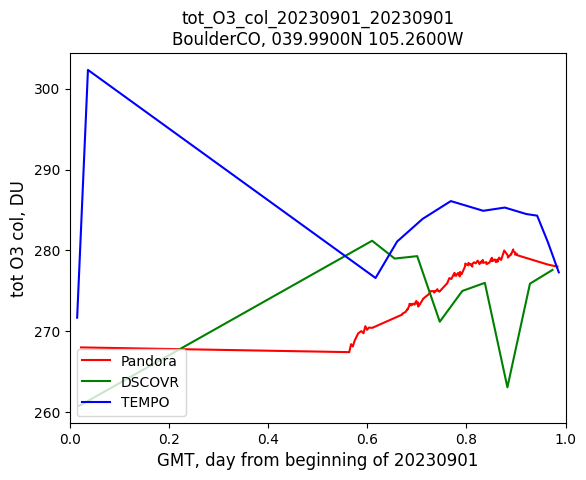

In [ ]:
# No error bars
plot_title = out_Q+'_'+datestamp_ini+'_'+datestamp_fin+'\n'+POI_name
img_name = out_Q+'_'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name+'.jpg'

plt.plot(time_series_Pandora[:, 0], time_series_Pandora[:, 1],\
         label = "Pandora", c = 'r')
plt.plot(time_series_DSCOVR[:, 0], time_series_DSCOVR[:, 1],
         label = "DSCOVR", c = 'g')
plt.plot(time_series_TEMPO[:, 0], time_series_TEMPO[:, 1],
         label = "TEMPO", c = 'b')

# Set the range of x-axis
l_lim = 0.
u_lim = ((dt_fin - dt0).total_seconds() + 1.)/86400.
plt.xlim(l_lim, u_lim)

# some research is required to set the vertical range
# Set the range of y-axis
#l_lim = 275
#u_lim = 375
#plt.ylim(l_lim, u_lim)

plt.xlabel(r'GMT, day from beginning of '+datestamp_ini, fontsize=12)
plt.ylabel(out_Q_unit.replace('_',' '), fontsize=12)

plt.legend(loc='lower left')

plt.title(plot_title+str(', %08.4fN %08.4fW' %(POI[0], -POI[1])))
plt.savefig(img_name, format='jpg', dpi=300)

###7.4.2 Plotting TEMPO and smoothed Pandora retievals with error bars

(102, 3)
(12, 2)
(10, 2)


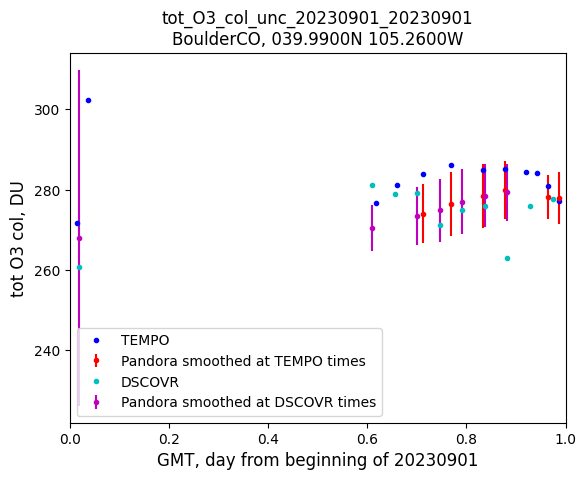

In [ ]:
print(time_series_Pandora.shape)
print(time_series_TEMPO.shape)
print(time_series_DSCOVR.shape)

timeseries_Pandora_TEMPO = gauss_interpolation(time_series_Pandora[:, 0:3],\
                                                time_series_TEMPO[:, 0])

timeseries_Pandora_DSCOVR = gauss_interpolation(time_series_Pandora[:, 0:3],\
                                                time_series_DSCOVR[:, 0])

plot_title = out_Q+'_unc_'+datestamp_ini+'_'+datestamp_fin+'\n'+POI_name
img_name = out_Q+'_unc_'+'_'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name+'.jpg'

fig = plt.figure()

plt.errorbar(time_series_TEMPO[:, 0], time_series_TEMPO[:, 1],\
yerr=None, label = "TEMPO", c = 'b', ls = '', marker = ".")

plt.errorbar(timeseries_Pandora_TEMPO[:, 0],\
             timeseries_Pandora_TEMPO[:, 1],\
             yerr=timeseries_Pandora_TEMPO[:, 2],\
             label = "Pandora smoothed at TEMPO times",\
             c = 'r', ls = '', marker = ".")

plt.errorbar(time_series_DSCOVR[:, 0], time_series_DSCOVR[:, 1],\
yerr=None, label = "DSCOVR", c = 'c', ls = '', marker = ".")

plt.errorbar(timeseries_Pandora_DSCOVR[:, 0],\
             timeseries_Pandora_DSCOVR[:, 1],\
             yerr=timeseries_Pandora_DSCOVR[:, 2],\
             label = "Pandora smoothed at DSCOVR times",\
             c = 'm', ls = '', marker = ".")

# Set the range of x-axis
l_lim = 0.
u_lim = ((dt_fin - dt0).total_seconds() + 1.)/86400.
plt.xlim(l_lim, u_lim)

# Set the range of y-axis
#l_lim = 275
#u_lim = 375
#plt.ylim(l_lim, u_lim)

plt.xlabel(r'GMT, day from beginning of '+datestamp_ini, fontsize=12)
plt.ylabel(out_Q_unit.replace('_',' '), fontsize=12)

#plt.legend(loc='upper left')
plt.legend(loc='lower left')

plt.title(plot_title+str(', %08.4fN %08.4fW' %(POI[0], -POI[1])))
plt.savefig(img_name, format='jpg', dpi=300)

##7.5 Plotting scatter plots along with regressions

###7.5.1 TEMPO

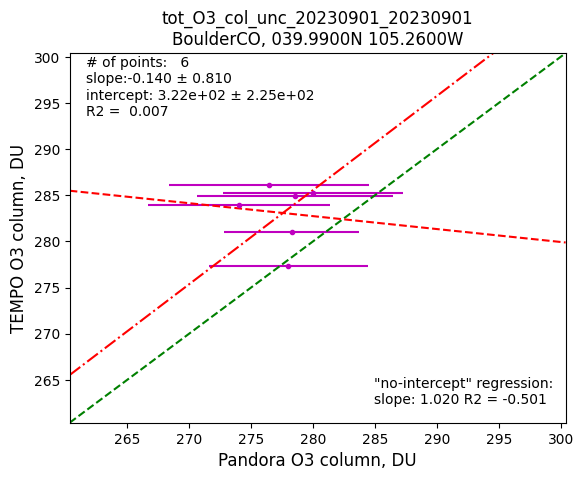

In [ ]:
TEMPO_Pandora_scatter = np.empty([0, 3])
for td in time_series_TEMPO:
  for pd in timeseries_Pandora_TEMPO:
    if td[0] == pd[0]:
      TEMPO_Pandora_scatter = np.append(TEMPO_Pandora_scatter,[[pd[1], td[1], pd[2]]], axis = 0)
      break

regress = stats.linregress(TEMPO_Pandora_scatter[:, 0], TEMPO_Pandora_scatter[:, 1])
slope = regress.slope
intercept = regress.intercept
r2 = regress.rvalue**2
stderr = regress.stderr
intercept_stderr = regress.intercept_stderr

success, slope_0intercept, r2_0intercept =\
 regress_0intercept(TEMPO_Pandora_scatter[:, 0]\
                  , TEMPO_Pandora_scatter[:, 1])

plot_title = out_Q+'_unc_'+datestamp_ini+'_'+datestamp_fin+'\n'+POI_name
img_name = 'TEMPO_vs_Pandora_scatter_'+out_Q+'_unc_'\
+datestamp_ini+'_'+datestamp_fin+'_'+POI_name+'.jpg'

fig = plt.figure()

plt.errorbar(TEMPO_Pandora_scatter[:, 0],\
             TEMPO_Pandora_scatter[:, 1],\
             xerr=TEMPO_Pandora_scatter[:, 2],\
             c = 'm', ls = '', marker = ".")

plt.xlabel(r'Pandora O3 column, DU', fontsize=12)
plt.ylabel(r'TEMPO O3 column, DU', fontsize=12)

fig.text(0.15, 0.75,\
str('# of points: %3i\nslope:%6.3f ±%6.3f\nintercept: %8.2e ± %8.2e\nR2 = %6.3f'\
 %(len(TEMPO_Pandora_scatter), slope, stderr, intercept, intercept_stderr, r2)))

# Set the range of x-axis
l_lim = min(TEMPO_Pandora_scatter[:, [0,1]].flatten())*0.95
u_lim = max(TEMPO_Pandora_scatter[:, [0,1]].flatten())*1.05
plt.xlim(l_lim, u_lim)
plt.ylim(l_lim, u_lim)

plt.plot([l_lim, u_lim], [l_lim, u_lim],\
c = 'g', ls = '--')

plt.plot([l_lim, u_lim], [l_lim*slope+intercept, u_lim*slope+intercept],\
c = 'r', ls = '--')

if success:
  plt.plot([l_lim, u_lim], [l_lim*slope_0intercept, u_lim*slope_0intercept], c = 'r', ls = '-.')
  fig.text(0.6, 0.15, str('"no-intercept" regression:\nslope:%6.3f R2 = %6.3f'\
 %(slope_0intercept, r2_0intercept)))

plt.title(plot_title+str(', %08.4fN %08.4fW' %(POI[0], -POI[1])))
plt.savefig(img_name, format='jpg', dpi=300)

###7.5.2 DSCOVR

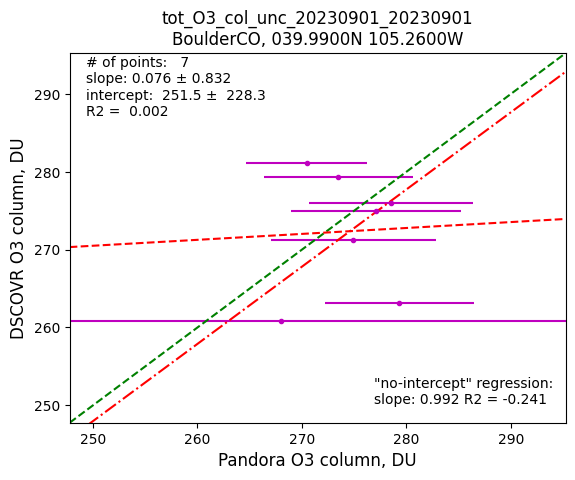

In [ ]:
DSCOVR_Pandora_scatter = np.empty([0, 3])
for Dd in time_series_DSCOVR:
  for pd in timeseries_Pandora_DSCOVR:
    if Dd[0] == pd[0]:
      DSCOVR_Pandora_scatter = np.append(DSCOVR_Pandora_scatter,[[pd[1], Dd[1], pd[2]]], axis = 0)
      break

regress = stats.linregress(DSCOVR_Pandora_scatter[:, 0], DSCOVR_Pandora_scatter[:, 1])
slope = regress.slope
intercept = regress.intercept
r2 = regress.rvalue**2
stderr = regress.stderr
intercept_stderr = regress.intercept_stderr

success, slope_0intercept, r2_0intercept =\
 regress_0intercept(DSCOVR_Pandora_scatter[:, 0]\
                  , DSCOVR_Pandora_scatter[:, 1])

plot_title = out_Q+'_unc_'+datestamp_ini+'_'+datestamp_fin+'\n'+POI_name
img_name = 'DSCOVR_vs_Pandora_scatter_'+out_Q+'_unc_'\
+datestamp_ini+'_'+datestamp_fin+'_'+POI_name+'.jpg'

fig = plt.figure()

plt.errorbar(DSCOVR_Pandora_scatter[:, 0],\
             DSCOVR_Pandora_scatter[:, 1],\
             xerr=DSCOVR_Pandora_scatter[:, 2],\
             c = 'm', ls = '', marker = ".")

plt.xlabel(r'Pandora O3 column, DU', fontsize=12)
plt.ylabel(r'DSCOVR O3 column, DU', fontsize=12)

fig.text(0.15, 0.75,\
str('# of points: %3i\nslope:%6.3f ±%6.3f\nintercept: %6.1f ± %6.1f\nR2 = %6.3f'\
 %(len(DSCOVR_Pandora_scatter), slope, stderr, intercept, intercept_stderr, r2)))

# Set the range of x-axis
l_lim = min(DSCOVR_Pandora_scatter[:, [0,1]].flatten())*0.95
u_lim = max(DSCOVR_Pandora_scatter[:, [0,1]].flatten())*1.05
plt.xlim(l_lim, u_lim)
plt.ylim(l_lim, u_lim)

plt.plot([l_lim, u_lim], [l_lim, u_lim],\
c = 'g', ls = '--')

plt.plot([l_lim, u_lim], [l_lim*slope+intercept, u_lim*slope+intercept],\
c = 'r', ls = '--')

if success:
  plt.plot([l_lim, u_lim], [l_lim*slope_0intercept, u_lim*slope_0intercept], c = 'r', ls = '-.')
  fig.text(0.6, 0.15, str('"no-intercept" regression:\nslope:%6.3f R2 = %6.3f'\
 %(slope_0intercept, r2_0intercept)))

plt.title(plot_title+str(', %08.4fN %08.4fW' %(POI[0], -POI[1])))
plt.savefig(img_name, format='jpg', dpi=300)

#EXTRA. Archiving output files to make downloading easier

In [ ]:
import zipfile
import zlib
import glob

In [ ]:
list_jpg = glob.glob('*'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name+'.jpg')

with zipfile.ZipFile('fig_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name+'.zip', 'w') as fig_zip:
  for name in list_jpg: fig_zip.write(name)

In [ ]:
list_data = glob.glob('*'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name+'*.txt')

with zipfile.ZipFile('data_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name+'.zip', 'w') as data_zip:
  for name in list_data: data_zip.write(name)